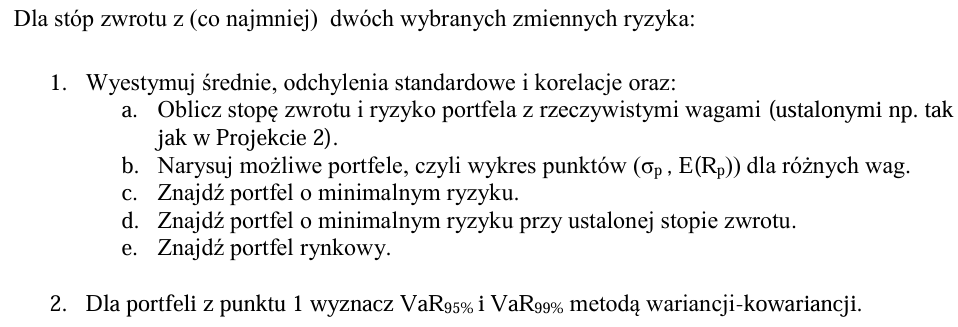

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar

In [2]:
# Wczytaj plik
df1 = pd.read_csv('fuel_output.csv', sep=';')
df2 = pd.read_csv('merged_output.csv', sep=';')
# Wyodrębnij kolumny do zmiennych
#dates = pd.to_datetime(df['Date'])

fuel_data = df1['fuel_data']
beef_data=df2['beef_data']

fuel_returns = np.log(fuel_data / fuel_data.shift(1)).dropna()
beef_returns = np.log(beef_data / beef_data.shift(1)).dropna()

# 1. Statystyki

In [3]:
### PALIWO
mean_returns_f = fuel_returns.mean()
std_devs_f = fuel_returns.std()
#cov_matrix = fuel_returns.cov()
#correlation = fuel_returns.corr()

print("Średnie stopy zwrotu:\n", mean_returns_f)
print("\nOdchylenia standardowe:\n", std_devs_f)


Średnie stopy zwrotu:
 0.0010584922842003712

Odchylenia standardowe:
 0.01686179481992683


In [4]:
### WOLOWINA
mean_returns_b = beef_returns.mean()
std_devs_b = beef_returns.std()

print("Średnie stopy zwrotu:\n", mean_returns_b)
print("\nOdchylenia standardowe:\n", std_devs_b)


Średnie stopy zwrotu:
 -0.00014511107802290383

Odchylenia standardowe:
 0.027503848821220696


In [5]:
# KORELACJA MIEDZY NIMI
correlation = np.corrcoef(beef_returns,fuel_returns)
print(correlation)

[[1.         0.00780695]
 [0.00780695 1.        ]]


## a) stopa zwrotu i ryzyko portfela

In [6]:
cov_matrix=np.cov([beef_returns, fuel_returns])
### USUNIĘTE MINUSY 
mean_returns=np.array([mean_returns_b, mean_returns_f])
std_devs=np.array([std_devs_b, std_devs_f])

weights = np.array([0.5, 0.5]) 
port_return = np.dot(weights, mean_returns)
port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f"Stopa zwrotu portfela: {port_return:.4f}")
print(f"Ryzyko portfela (σ): {port_std:.4f}")


Stopa zwrotu portfela: 0.0005
Ryzyko portfela (σ): 0.0162


## b) wykres z wagami

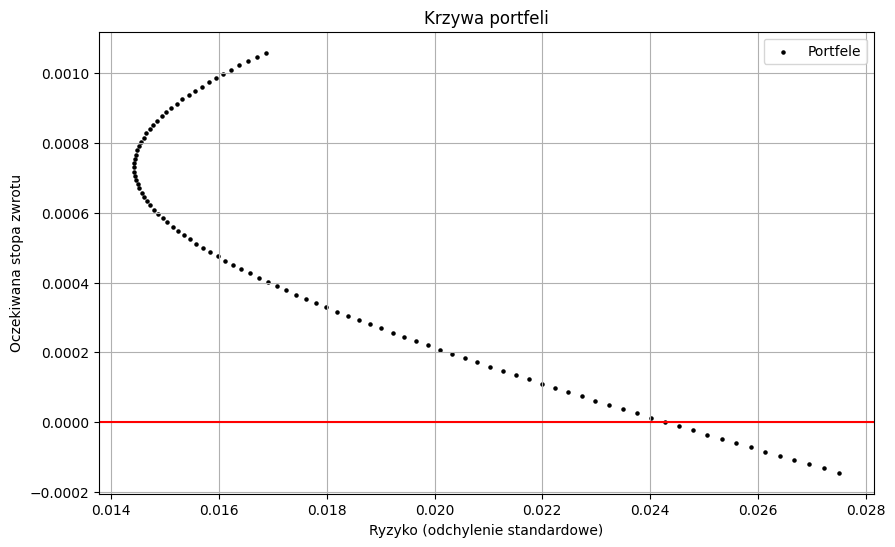

In [8]:
weights_range = np.linspace(0, 1, 100)
returns_list = []
stds_list = []

for w in weights_range:
    w_vec = np.array([w, 1-w])
    r = np.dot(w_vec, mean_returns)
    s = np.sqrt(np.dot(w_vec.T, np.dot(cov_matrix, w_vec)))
    returns_list.append(r)
    stds_list.append(s)

plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, s=5, color = "black", label="Portfele")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.axhline(y=0, color='red')
plt.grid(True)
plt.legend()
#plt.ylim(0,0.0012)
plt.show()


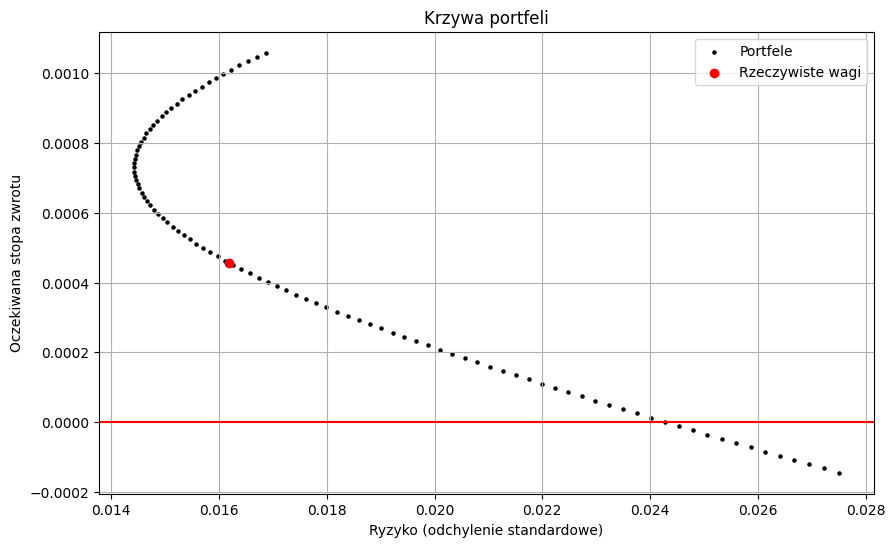

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, s=5, color = "black", label="Portfele")
plt.scatter(port_std, port_return, color='red', label='Rzeczywiste wagi', zorder=5)
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.axhline(y=0, color='red')
plt.grid(True)
#plt.ylim(0,0.0012)
plt.legend()
plt.show()

## c) minimalne ryzyko

In [10]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

print("Wagi portfela minimalnego ryzyka:", w_min_var)


Wagi portfela minimalnego ryzyka: [0.27159023 0.72840977]


In [11]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# wagi portfela minimalnego ryzyka
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

# stopa zwrotu i ryzyko tego portfela
r_min_var = np.dot(w_min_var, mean_returns)
std_min_var = np.sqrt(np.dot(w_min_var.T, np.dot(cov_matrix, w_min_var)))

print("Stopa zwrotu portfela o minimalnym ryzyku:", r_min_var)
print("Odchylenie standardowe portfela o minimalnym ryzyku:", std_min_var)


Stopa zwrotu portfela o minimalnym ryzyku: 0.0007316053756844118
Odchylenie standardowe portfela o minimalnym ryzyku: 0.014425147257820958


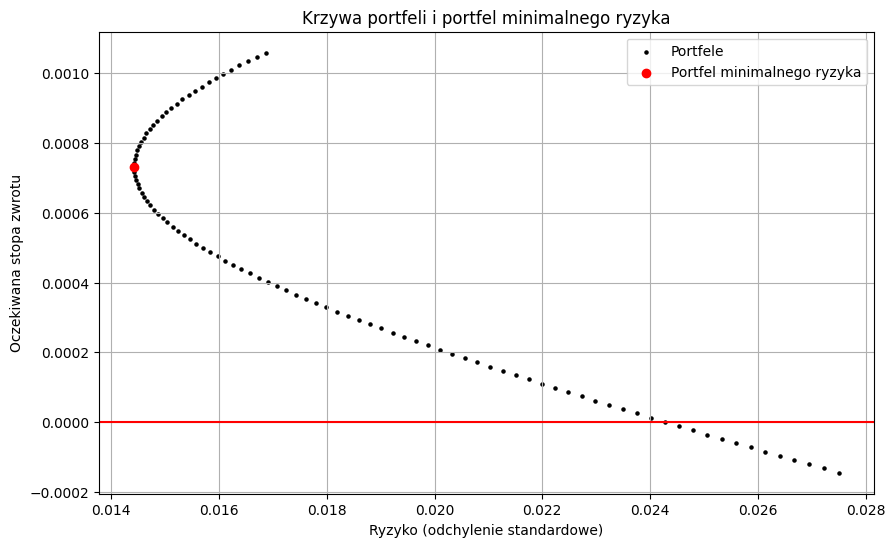

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='red', label='Portfel minimalnego ryzyka', zorder=5)
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli i portfel minimalnego ryzyka")
plt.grid(True)
plt.legend()
# plt.ylim(0,0.0012)
plt.axhline(y=0, color='red')
plt.show()


## d) minimalne ryzyko przy ustalonej stopie zwrotu

In [14]:
### TO NA PLUSIE CZY NA MINUSIE????
target_return = 0.001

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

lambda_1 = (C * target_return - B) / D
lambda_2 = (A - B * target_return) / D

w_target = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
print("Wagi portfela dla ustalonej stopy zwrotu:", w_target)

Wagi portfela dla ustalonej stopy zwrotu: [0.04859764 0.95140236]


In [15]:
print("Dla wag 1 i 0 (ten czubek)")
print("sigma:",stds_list[0])
print("zwrot:", returns_list[0])

Dla wag 1 i 0 (ten czubek)
sigma: 0.01686179481992683
zwrot: 0.0010584922842003712


In [17]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []
weights_1 = [] 
weights_2 = []

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

for target_return in target_returns:
    lambda_1 = (C * target_return - B) / D
    lambda_2 = (A - B * target_return) / D

    w = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
    sigma = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(sigma)
    weights_1.append(w[0])
    weights_2.append(w[1])

In [18]:
# Tworzenie DataFrame
df_portfele = pd.DataFrame({
    'Oczekiwana stopa zwrotu': target_returns,
    'Ryzyko (odchylenie standardowe)': risks,
    'Waga wołowiny': weights_1,
    'Waga paliwa': weights_2
})

df_portfele

,Oczekiwana stopa zwrotu,Ryzyko (odchylenie standardowe),Waga wołowiny,Waga paliwa
0,-0.000145,0.027504,1.000000e+00,0.000000
1,-0.000133,0.027228,9.898990e-01,0.010101
2,-0.000121,0.026953,9.797980e-01,0.020202
3,-0.000109,0.026679,9.696970e-01,0.030303
4,-0.000096,0.026407,9.595960e-01,0.040404
...,...,...,...,...
95,0.001010,0.016227,4.040404e-02,0.959596
96,0.001022,0.016379,3.030303e-02,0.969697
97,0.001034,0.016535,2.020202e-02,0.979798
98,0.001046,0.016696,1.010101e-02,0.989899


DLa średniej stopy zwrottu dla portfeli efektywnych

In [19]:
mean_returns_effective = np.mean([r for r in returns_list if r > r_min_var])
lambda_1 = (C * mean_returns_effective - B) / D
lambda_2 = (A - B * mean_returns_effective) / D

w_mean_returns_effective = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
sigma_mean_returns_effective = np.sqrt(np.dot(w_mean_returns_effective.T, np.dot(cov_matrix, w_mean_returns_effective)))

print("Odchylenie standardowe ustalonej stopy zwrotu:", sigma_mean_returns_effective)
print("Średnia stopa zwrotu dla efektywnych portfeli:", mean_returns_effective)
print("Wagi portfela dla ustalonej stopy zwrotu:", w_mean_returns_effective)

Odchylenie standardowe ustalonej stopy zwrotu: 0.01511365403339358
Średnia stopa zwrotu dla efektywnych portfeli: 0.00090044335784782
Wagi portfela dla ustalonej stopy zwrotu: [0.13131313 0.86868687]


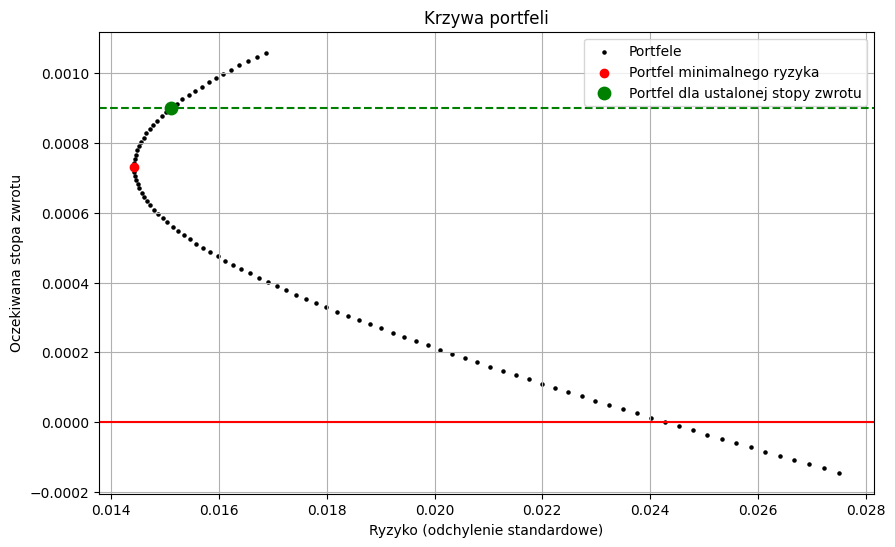

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='red', label='Portfel minimalnego ryzyka', zorder=5)
plt.scatter(sigma_mean_returns_effective, mean_returns_effective, color = "green", s = 80, label = "Portfel dla ustalonej stopy zwrotu")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.grid(True)
plt.legend()
# plt.ylim(0,0.0012)
plt.axhline(y=0, color='red')
plt.axhline( y=mean_returns_effective, color='green', linestyle='--', label=f"Ustalona stopa zwrotu = {mean_returns_effective:.6f}")
plt.show()

## e) stopa wolna rynkowa 

In [21]:
returns = pd.concat([beef_returns, fuel_returns], axis=1)
#returns.columns = ['beef', 'fuel']  # nadaj nazwy, jeśli ich brak

# Teraz policz średnie i odchylenia jako Series z nazwami
mean_returns = returns.mean()
std_devs = returns.std()


In [22]:
mean_returns

beef_data   -0.000145
fuel_data    0.001058
dtype: float64

In [23]:
r_f =  - 0.001

excess_returns = mean_returns - r_f
sharpe_ratios =pd.Series(excess_returns / std_devs)

# Portfel rynkowy = maksymalny wskaźnik Sharpe'a
best_idx = sharpe_ratios.idxmax()
print(f"Najlepszy składnik portfela rynkowego: {best_idx}")


Najlepszy składnik portfela rynkowego: fuel_data


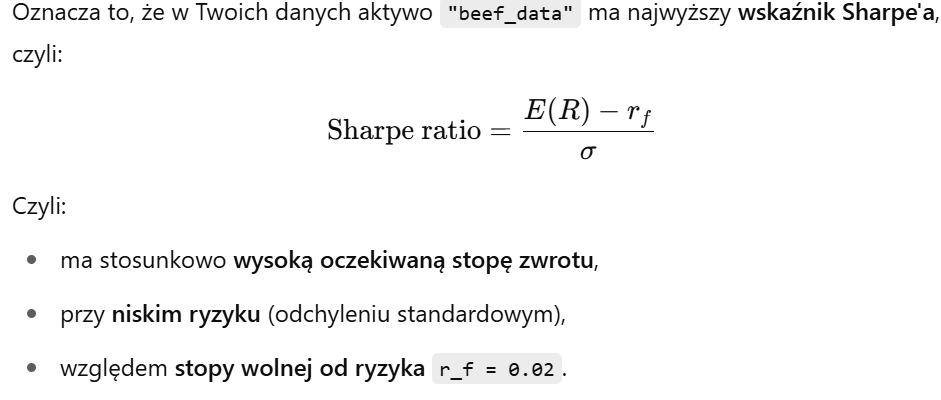

In [24]:
import numpy as np

# Stałe
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# Tangency portfolio (maksymalny Sharpe ratio)
excess = mean_returns - r_f
numerator = np.dot(inv_cov, excess)
denominator = np.dot(ones.T, numerator)
w_market = numerator / denominator

# Parametry portfela rynkowego
R_market = np.dot(w_market, mean_returns)
σ_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))

print(f"Portfel rynkowy:\nWagi: {w_market}\nOczekiwana stopa zwrotu: {R_market:.4f}\nRyzyko: {σ_market:.4f}")


Portfel rynkowy:
Wagi: [0.13164844 0.86835156]
Oczekiwana stopa zwrotu: 0.0009
Ryzyko: 0.0151


In [25]:
### MOJE
# sharpe_market = (R_market - r_f) / σ_market
# print(f"r_f = {r_f:.6f}")
# print(f"R_market = {R_market:.6f}")
# print(f"σ_market = {σ_market:.6f}")
# print(f"Sharpe ratio = {sharpe_market:.2f}")


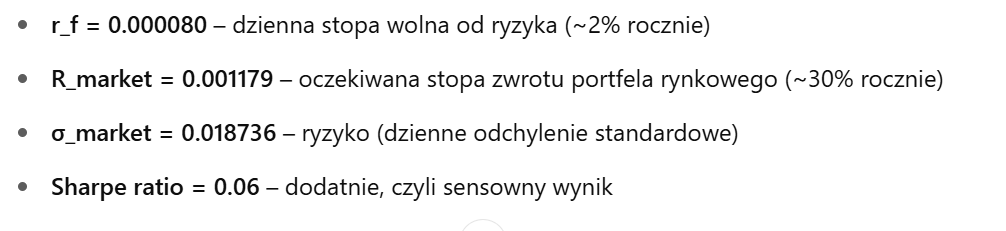

In [26]:
sharpe_market = (R_market - r_f) / σ_market
print(f"Wskaźnik Sharpe’a portfela rynkowego: {sharpe_market:.4f}")

Wskaźnik Sharpe’a portfela rynkowego: 0.1257


In [27]:
#target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)

risks = []
A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

risks = []
for R_target in target_returns:
    λ1 = (C * R_target - B) / D
    λ2 = (A - B * R_target) / D
    w = λ1 * np.dot(inv_cov, mean_returns) + λ2 * np.dot(inv_cov, ones)
    σ = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(σ)



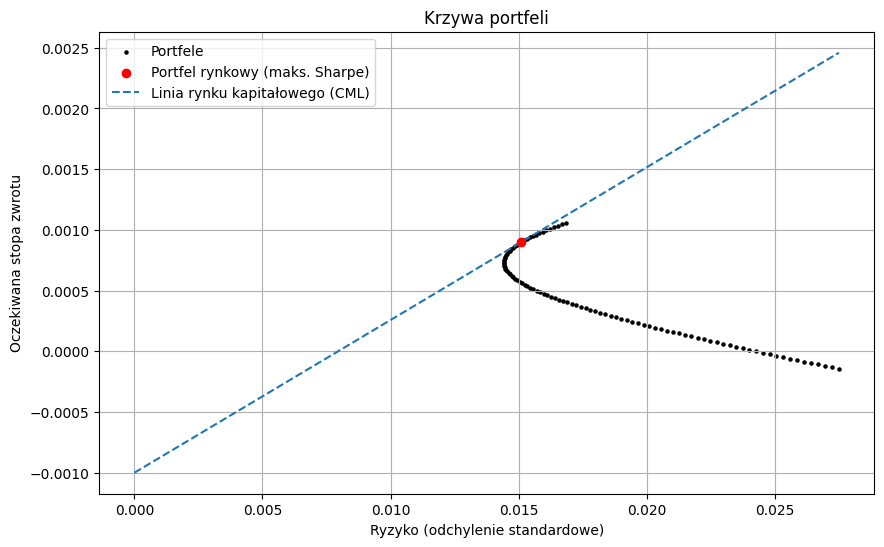

Odchylenie standardowe: 0.015110440999643503
Oczekiwana stopa zwrotu: 0.0009000397802713231


In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, s=5, color = "black", label="Portfele")
plt.scatter(σ_market, R_market, color='red', label='Portfel rynkowy (maks. Sharpe)', zorder=5)

# CML – linia rynku kapitałowego
σ_cml = np.linspace(0, max(risks), 100)
R_cml = r_f + (R_market - r_f) / σ_market * σ_cml
plt.plot(σ_cml, R_cml, label='Linia rynku kapitałowego (CML)', linestyle='--')


plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.grid(True)
plt.legend()
# plt.ylim(0,0.0012)
# plt.xlim(0,0.028)
plt.show()

print("Odchylenie standardowe:", σ_market) 
print("Oczekiwana stopa zwrotu:",R_market)

Kod porównujący, dla których r_f wskaźnik Sharpe’a jest najlepszy => im niższe r_f tym wskaźnik jest wyższy

In [516]:
"""import numpy as np
import pandas as pd

inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# Przedział wartości r_f
r_f_values = np.linspace(-0.001, 0.001, 100)
best_sharpe = -np.inf
best_r_f = None
best_weights = None
best_R = None
best_sigma = None

for r_f in r_f_values:
    excess = mean_returns - r_f
    numerator = np.dot(inv_cov, excess)
    denominator = np.dot(ones.T, numerator)
    w_market = numerator / denominator

    R_market = np.dot(w_market, mean_returns)
    sigma_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))

    sharpe = (R_market - r_f) / sigma_market

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_r_f = r_f
        best_weights = w_market
        best_R = R_market
        best_sigma = sigma_market

# Wynik
print(f"Najlepsze r_f: {best_r_f:.6f}")
print(f"Najwyższy wskaźnik Sharpe’a: {best_sharpe:.4f}")
print(f"Oczekiwana stopa zwrotu portfela: {best_R:.4f}")
print(f"Ryzyko portfela (σ): {best_sigma:.4f}")
print("Wagi portfela:")
for i, w in enumerate(best_weights):
    print(f"  Aktywum {i+1}: {w:.4f}")"""


'import numpy as np\nimport pandas as pd\n\ninv_cov = np.linalg.inv(cov_matrix)\nones = np.ones(len(mean_returns))\n\n# Przedział wartości r_f\nr_f_values = np.linspace(-0.001, 0.001, 100)\nbest_sharpe = -np.inf\nbest_r_f = None\nbest_weights = None\nbest_R = None\nbest_sigma = None\n\nfor r_f in r_f_values:\n    excess = mean_returns - r_f\n    numerator = np.dot(inv_cov, excess)\n    denominator = np.dot(ones.T, numerator)\n    w_market = numerator / denominator\n\n    R_market = np.dot(w_market, mean_returns)\n    sigma_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))\n\n    sharpe = (R_market - r_f) / sigma_market\n\n    if sharpe > best_sharpe:\n        best_sharpe = sharpe\n        best_r_f = r_f\n        best_weights = w_market\n        best_R = R_market\n        best_sigma = sigma_market\n\n# Wynik\nprint(f"Najlepsze r_f: {best_r_f:.6f}")\nprint(f"Najwyższy wskaźnik Sharpe’a: {best_sharpe:.4f}")\nprint(f"Oczekiwana stopa zwrotu portfela: {best_R:.4f}")\nprint(

Podsumowanie

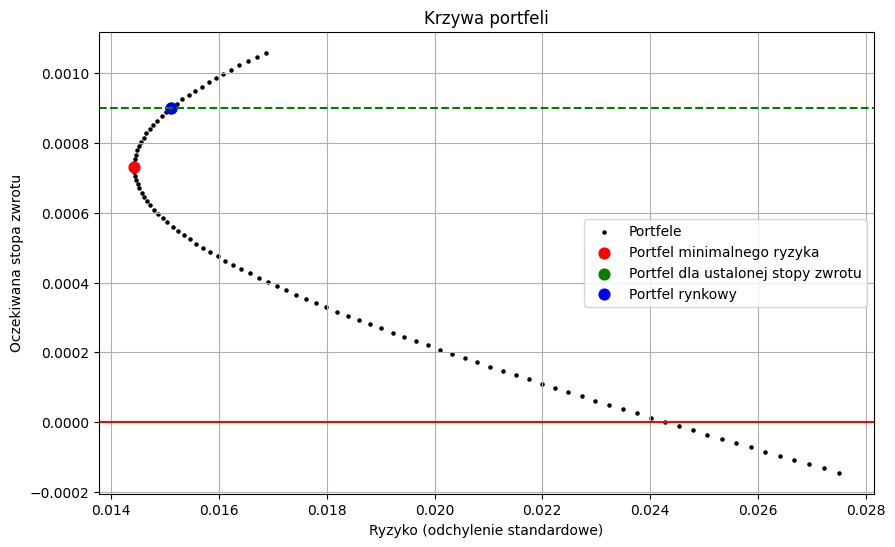

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, color='black', s=5, label="Portfele")
plt.scatter(std_min_var, r_min_var, color='red', s = 60, label='Portfel minimalnego ryzyka')
#TE DWA PORTFELE NACHODZĄ NA SIEBIE
plt.scatter(sigma_mean_returns_effective, mean_returns_effective, color = "green", s = 60, label = "Portfel dla ustalonej stopy zwrotu")
plt.scatter(σ_market, R_market, color = "blue", s = 60, label = "Portfel rynkowy")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.grid(True)
plt.legend()
plt.axhline(y=0, color='red')
plt.axhline( y=mean_returns_effective, color='green', linestyle='--', label=f"Ustalona stopa zwrotu = {mean_returns_effective:.6f}")
plt.show()

# 2.

In [518]:
#Macierz kowariancji
cov_matrix = returns.cov()
print(cov_matrix)

           beef_data  fuel_data
beef_data   0.000756   0.000004
fuel_data   0.000004   0.000284


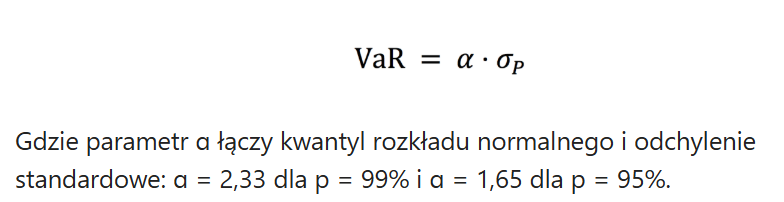

In [519]:
def VaR(w):
    sigma_p = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))

    z_95 = norm.ppf(0.95)
    z_99 = norm.ppf(0.99)

    VaR_95 = z_95*sigma_p
    VaR_99 = z_99*sigma_p

    return(VaR_95, VaR_99)

In [520]:
VaR_rzeczywiste = VaR(weights)
VaR_min_var = VaR(w_min_var)
VaR_mean_returns_effective = VaR(w_mean_returns_effective)
VaR_market = VaR(w_market)

In [521]:
data = {
    '': ['VaR95', 'VaR99'],
    'Rzeczywisty': VaR_rzeczywiste,
    'Minimalnego ryzyka': VaR_min_var,
    'Ustalona stopa zwrotu': VaR_mean_returns_effective,
    'Rynkowy': VaR_market
}

df_VaR = pd.DataFrame(data)
df_VaR

,,Rzeczywisty,Minimalnego ryzyka,Ustalona stopa zwrotu,Rynkowy
0,VaR95,0.026625,0.023727,0.02486,0.024854
1,VaR99,0.037656,0.033558,0.03516,0.035152
